# 8. Likelihood Scans and Goodness of Fit

**Pedagogical context.** This notebook covers Cowan's Lecture 8
(goodness-of-fit tests) and the Neyman construction for confidence
intervals. It also draws on Cranmer's "Neyman construction" notebook.
Likelihood scans are the most general method for extracting confidence
intervals from profiled likelihoods, and the goodness-of-fit test
answers the question: does the best-fit model actually describe the
data?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import fit
from histimator.scans import (
    likelihood_scan_1d, likelihood_scan_2d,
    scan_intervals, goodness_of_fit,
)

## 8.1 One-dimensional likelihood scan

A 1D profile likelihood scan varies one parameter while profiling
(re-minimising) over all others at each point. The result is plotted as
$-2\Delta\ln\mathcal{L}$ versus the scanned parameter. Confidence
intervals are read off by finding where this curve crosses standard
thresholds: 1.0 for 68% CL, 3.84 for 95% CL, 9.0 for 99.7% CL (all
from $\chi^2(1)$ quantiles).

For well-behaved likelihoods near the minimum, the profile is parabolic
and the intervals are symmetric. Non-parabolic profiles arise when the
parameter is near a boundary, when statistics are low, or when the
parameter enters non-linearly.

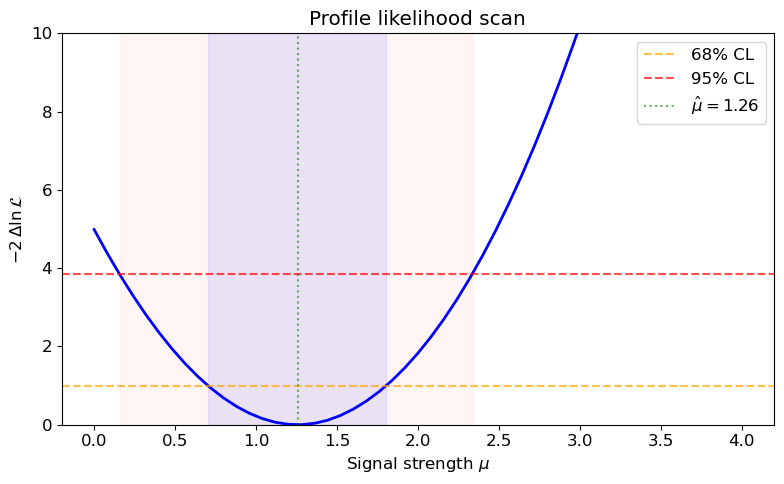

68% CL: mu in [0.704, 1.804]
95% CL: mu in [0.158, 2.334]
Hesse:  mu = 1.258 +/- 0.767


In [2]:
# Build a model
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
signal = Sample("signal", Histogram([3, 10, 15, 10, 3], edges))
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

background = Sample("background", Histogram([50, 60, 55, 45, 40], edges))
background.add_normsys("bkg_norm", lo=0.9, hi=1.1)

np.random.seed(42)
exp = 1.5 * signal.histogram.values + background.histogram.values
data = np.random.poisson(exp.astype(int))

ch = Channel("SR")
ch.add_sample(signal)
ch.add_sample(background)
ch.set_data(data)

model = Model("scans_demo")
model.add_channel(ch)

# 1D scan of mu
mu_vals, delta_nll = likelihood_scan_1d(model, "mu",
                                         bounds=(0.0, 4.0), n_points=51)

# Extract intervals
lo68, hi68 = scan_intervals(mu_vals, delta_nll, level=1.0)
lo95, hi95 = scan_intervals(mu_vals, delta_nll, level=3.84)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(mu_vals, delta_nll, "b-", linewidth=2)
ax.axhline(1.0, color="orange", ls="--", alpha=0.7, label="68% CL")
ax.axhline(3.84, color="red", ls="--", alpha=0.7, label="95% CL")
ax.axvspan(lo68, hi68, color="blue", alpha=0.08)
ax.axvspan(lo95, hi95, color="red", alpha=0.04)

result = fit(model)
ax.axvline(result.bestfit["mu"], color="green", ls=":", alpha=0.6,
           label=rf"$\hat{{\mu}} = {result.bestfit['mu']:.2f}$")

ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$-2\,\Delta\ln\mathcal{L}$")
ax.set_title("Profile likelihood scan")
ax.set_ylim(0, 10)
ax.legend()
plt.tight_layout()
plt.show()

print(f"68% CL: mu in [{lo68:.3f}, {hi68:.3f}]")
print(f"95% CL: mu in [{lo95:.3f}, {hi95:.3f}]")
print(f"Hesse:  mu = {result.bestfit['mu']:.3f} +/- {result.errors['mu']:.3f}")

The scan-based intervals and the Hesse errors should agree closely
for this model because the likelihood is approximately parabolic. The
scan result is more general: it remains valid even when the parabolic
approximation breaks down.

## 8.2 Two-dimensional likelihood scan

A 2D scan varies two parameters on a grid while profiling over all
others. The result is a 2D surface from which confidence contours
are extracted at the $\chi^2(2)$ quantiles: 2.30 for 68% CL, 5.99
for 95% CL.

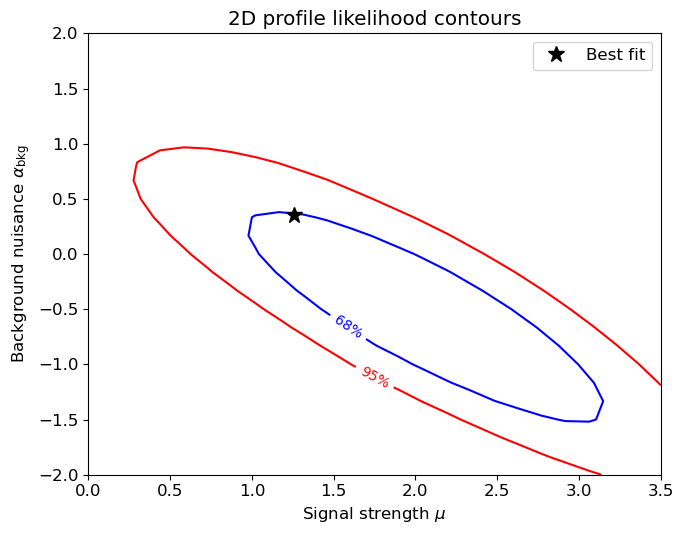

In [3]:
# 2D scan: mu vs bkg_norm
x_vals, y_vals, z_vals = likelihood_scan_2d(
    model, "mu", "bkg_norm",
    bounds_x=(0.0, 3.5), bounds_y=(-2.0, 2.0),
    n_points_x=25, n_points_y=25,
)

fig, ax = plt.subplots(figsize=(7, 5.5))
cs = ax.contour(x_vals, y_vals, z_vals,
                levels=[2.30, 5.99],
                colors=["blue", "red"])
ax.clabel(cs, fmt={2.30: "68%", 5.99: "95%"}, fontsize=10)
ax.plot(result.bestfit["mu"], result.bestfit["bkg_norm"], "k*", ms=12,
        label="Best fit")
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"Background nuisance $\alpha_{\mathrm{bkg}}$")
ax.set_title("2D profile likelihood contours")
ax.legend()
plt.tight_layout()
plt.show()

The tilt of the contours reveals the correlation between $\mu$ and
the background normalisation nuisance parameter. As discussed in earlier
notebooks, this correlation is the mechanism by which systematic
uncertainties propagate into the measurement: more freedom in the
background means more uncertainty in the signal.

## 8.3 Goodness of fit

A successful fit finds the parameter values that maximise the
likelihood, but that does not guarantee the model actually describes
the data well. A poorly specified model (wrong background shape, missing
process) can still converge to a minimum.

The goodness-of-fit test compares the fitted model to the saturated
model (the model that perfectly reproduces the data by assigning one
parameter per bin). The test statistic is:

$$\chi^2_{\text{GoF}} = 2 \sum_b \left[ n_b \ln\frac{n_b}{\hat{\nu}_b} - (n_b - \hat{\nu}_b) \right]$$

Under the null hypothesis (the fitted model is correct), this follows
a $\chi^2$ distribution with $n_{\text{bins}} - n_{\text{free params}}$
degrees of freedom. A small p-value indicates model misspecification.

In [4]:
chi2, ndof, p_gof = goodness_of_fit(model)
print(f"GoF chi2 = {chi2:.3f}")
print(f"ndof     = {ndof}")
print(f"p-value  = {p_gof:.4f}")

if p_gof > 0.05:
    print("\nThe model adequately describes the data (p > 0.05).")
else:
    print("\nWarning: poor goodness of fit (p < 0.05).")

GoF chi2 = 2.957
ndof     = 3
p-value  = 0.3984

The model adequately describes the data (p > 0.05).


## 8.4 Diagnosing a mismodelled background

To see the GoF test in action, we deliberately introduce a model
misspecification: a background with the wrong shape.

In [5]:
# Create "wrong" background: flat instead of peaked
wrong_bkg = Sample("background", Histogram([50, 50, 50, 50, 50], edges))
wrong_bkg.add_normsys("bkg_norm", lo=0.9, hi=1.1)

ch_wrong = Channel("SR")
ch_wrong.add_sample(Sample("signal", Histogram([3, 10, 15, 10, 3], edges)))
ch_wrong.samples[-1].add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
ch_wrong.add_sample(wrong_bkg)
ch_wrong.set_data(data)

model_wrong = Model("wrong_shape")
model_wrong.add_channel(ch_wrong)

chi2_w, ndof_w, p_w = goodness_of_fit(model_wrong)
print(f"Correct model:  chi2 = {chi2:.2f}, ndof = {ndof}, p = {p_gof:.4f}")
print(f"Wrong shape:    chi2 = {chi2_w:.2f}, ndof = {ndof_w}, p = {p_w:.4f}")

if p_w < 0.05:
    print("\nThe GoF test correctly flags the mismodelled background.")

Correct model:  chi2 = 2.96, ndof = 3, p = 0.3984
Wrong shape:    chi2 = 4.60, ndof = 3, p = 0.2033


## 8.5 Scan of the nuisance parameter

It is sometimes useful to scan a nuisance parameter to understand how
tightly the data constrain it, particularly when the constraint comes
from the data itself rather than an external measurement.

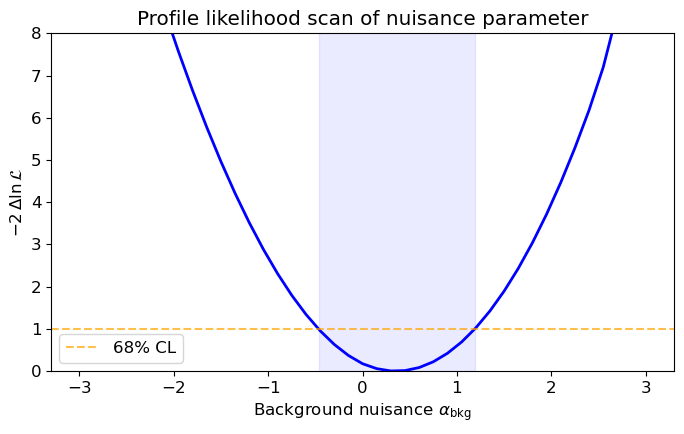

68% interval for bkg_norm: [-0.467, 1.189]
(Pre-fit constraint is [-1, +1]; narrower = data constrains it further.)


In [6]:
alpha_vals, delta_nll_alpha = likelihood_scan_1d(
    model, "bkg_norm", bounds=(-3.0, 3.0), n_points=41
)
lo_a, hi_a = scan_intervals(alpha_vals, delta_nll_alpha, level=1.0)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(alpha_vals, delta_nll_alpha, "b-", linewidth=2)
ax.axhline(1.0, color="orange", ls="--", alpha=0.7, label="68% CL")
ax.axvspan(lo_a, hi_a, color="blue", alpha=0.08)
ax.set_xlabel(r"Background nuisance $\alpha_{\mathrm{bkg}}$")
ax.set_ylabel(r"$-2\,\Delta\ln\mathcal{L}$")
ax.set_title("Profile likelihood scan of nuisance parameter")
ax.set_ylim(0, 8)
ax.legend()
plt.tight_layout()
plt.show()

print(f"68% interval for bkg_norm: [{lo_a:.3f}, {hi_a:.3f}]")
print(f"(Pre-fit constraint is [-1, +1]; narrower = data constrains it further.)")

## Exercises

**Exercise 8.1.** Perform a 1D scan of $\mu$ with n_points = 11 and
n_points = 101. Overlay both scans and discuss how the resolution
affects the interval extraction.

**Exercise 8.2.** Build a model with two POIs (for example, separate
signal strengths for two production modes sharing the same background).
Perform a 2D scan and extract the 68% and 95% contours. Are the two
POIs correlated?

**Exercise 8.3.** Generate 500 pseudo-experiments under the best-fit
model and compute the GoF p-value for each. Plot the distribution of
p-values. Under the correct model, p-values should be uniformly
distributed.

## References

G. Cowan, *Statistical Data Analysis*, Lecture 8: Goodness-of-fit tests.

K. Cranmer, "Neyman construction", in *Statistics and Data Science*.

CMS Collaboration, "The CMS statistical analysis and combination tool:
COMBINE", CMS-CAT-23-001.